In [1]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)


In [2]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [7]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [8]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [10]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [11]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [12]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [13]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [14]:
n_factors = 50

In [15]:
np.random.seed = 42

Randomly split into training and validation.

In [16]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [17]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [18]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [19]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [20]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [21]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [22]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [42]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [33]:
trn.userId.values

array([  0,   0,   0, ..., 670, 670, 670])

In [34]:
trn.movieId.values

array([   0,    1,    3, ..., 1329, 1331, 2946])

In [35]:
trn.rating.values

array([ 2.5,  3. ,  2. , ...,  4. ,  2.5,  3.5])

In [63]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80101 samples, validate on 19903 samples
Epoch 1/1
80101/80101 [==============================] - 3s - loss: 0.7367 - val_loss: 1.1335


In [64]:
model.optimizer.lr=0.01

In [65]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80101 samples, validate on 19903 samples
Epoch 1/3
80101/80101 [==============================] - 3s - loss: 0.7078 - val_loss: 1.1146
Epoch 2/3
80101/80101 [==============================] - 3s - loss: 0.6825 - val_loss: 1.0973
Epoch 3/3
80101/80101 [==============================] - 3s - loss: 0.6596 - val_loss: 1.0841


In [66]:
model.optimizer.lr=0.001

In [67]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80101 samples, validate on 19903 samples
Epoch 1/6
80101/80101 [==============================] - 3s - loss: 0.6396 - val_loss: 1.0722
Epoch 2/6
80101/80101 [==============================] - 3s - loss: 0.6223 - val_loss: 1.0624
Epoch 3/6
80101/80101 [==============================] - 3s - loss: 0.6069 - val_loss: 1.0553
Epoch 4/6
80101/80101 [==============================] - 2s - loss: 0.5943 - val_loss: 1.0480
Epoch 5/6
80101/80101 [==============================] - 2s - loss: 0.5835 - val_loss: 1.0436
Epoch 6/6
80101/80101 [==============================] - 2s - loss: 0.5741 - val_loss: 1.0396


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [68]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [69]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [70]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [71]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [86]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
#x = merge([x, ub], mode='sum')
#x = merge([x, mb], mode='sum')
x = merge([x, mb, ub], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [87]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80101 samples, validate on 19903 samples
Epoch 1/1
80101/80101 [==============================] - 3s - loss: 0.5960 - val_loss: 0.9663


In [88]:
model.optimizer.lr=0.01

In [89]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80101 samples, validate on 19903 samples
Epoch 1/6
80101/80101 [==============================] - 3s - loss: 0.5529 - val_loss: 0.9862
Epoch 2/6
80101/80101 [==============================] - 3s - loss: 0.5376 - val_loss: 1.0033
Epoch 3/6
80101/80101 [==============================] - 3s - loss: 0.5323 - val_loss: 1.0142
Epoch 4/6
80101/80101 [==============================] - 3s - loss: 0.5303 - val_loss: 1.0218
Epoch 5/6
80101/80101 [==============================] - 3s - loss: 0.5286 - val_loss: 1.0273
Epoch 6/6
80101/80101 [==============================] - 3s - loss: 0.5276 - val_loss: 1.0314


In [90]:
model.optimizer.lr=0.001

In [91]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80101 samples, validate on 19903 samples
Epoch 1/10
80101/80101 [==============================] - 3s - loss: 0.5264 - val_loss: 1.0350
Epoch 2/10
80101/80101 [==============================] - 3s - loss: 0.5257 - val_loss: 1.0373
Epoch 3/10
80101/80101 [==============================] - 3s - loss: 0.5248 - val_loss: 1.0403
Epoch 4/10
80101/80101 [==============================] - 3s - loss: 0.5242 - val_loss: 1.0410
Epoch 5/10
80101/80101 [==============================] - 3s - loss: 0.5238 - val_loss: 1.0429
Epoch 6/10
80101/80101 [==============================] - 3s - loss: 0.5229 - val_loss: 1.0437
Epoch 7/10
80101/80101 [==============================] - 3s - loss: 0.5227 - val_loss: 1.0454
Epoch 8/10
80101/80101 [==============================] - 3s - loss: 0.5224 - val_loss: 1.0466
Epoch 9/10
80101/80101 [==============================] - 3s - loss: 0.5214 - val_loss: 1.0477
Epoch 10/10
80101/80101 [==============================] - 3s - loss: 0.5216 - val_loss: 1.0483

In [92]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80101 samples, validate on 19903 samples
Epoch 1/5
80101/80101 [==============================] - 3s - loss: 0.5208 - val_loss: 1.0489
Epoch 2/5
80101/80101 [==============================] - 3s - loss: 0.5207 - val_loss: 1.0498
Epoch 3/5
80101/80101 [==============================] - 3s - loss: 0.5203 - val_loss: 1.0508
Epoch 4/5
80101/80101 [==============================] - 3s - loss: 0.5200 - val_loss: 1.0511
Epoch 5/5
80101/80101 [==============================] - 3s - loss: 0.5197 - val_loss: 1.0516


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [93]:
model.save_weights(model_path+'bias.h5')

In [94]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [95]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.148]], dtype=float32)

In [62]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [96]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [97]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [98]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-1.1956393, 'Battlefield Earth (2000)'),
 (-1.0774415, 'Super Mario Bros. (1993)'),
 (-1.0282662, 'Jaws 3-D (1983)'),
 (-0.98010707, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.94325739, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.89109313, 'House on Haunted Hill (1999)'),
 (-0.75687993, 'Police Academy 6: City Under Siege (1989)'),
 (-0.71427053, 'Howard the Duck (1986)'),
 (-0.70977336, 'Blade: Trinity (2004)'),
 (-0.69830799, 'Police Academy 3: Back in Training (1986)'),
 (-0.68114263, 'Spice World (1997)'),
 (-0.67844206, 'Speed 2: Cruise Control (1997)'),
 (-0.63469023, 'Anaconda (1997)'),
 (-0.61198348, 'Avengers, The (1998)'),
 (-0.5389635, 'Nutty Professor II: The Klumps (2000)')]

In [99]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.9755951, 'Ran (1985)'),
 (1.9658248, 'African Queen, The (1951)'),
 (1.921546, 'Thirty-Two Short Films About Glenn Gould (1993)'),
 (1.8986326, 'Killer, The (Die xue shuang xiong) (1989)'),
 (1.8718964, 'Cool Hand Luke (1967)'),
 (1.856287, 'American Movie (1999)'),
 (1.8547105, 'It Happened One Night (1934)'),
 (1.8213547, 'Mister Roberts (1955)'),
 (1.8205296, 'Roger & Me (1989)'),
 (1.8166956, 'Shawshank Redemption, The (1994)'),
 (1.815178, 'Philadelphia Story, The (1940)'),
 (1.8133115, 'All About Eve (1950)'),
 (1.8037233, 'Modern Times (1936)'),
 (1.7824596, 'Godfather, The (1972)'),
 (1.7817649, 'Inherit the Wind (1960)')]

We can now do the same thing for the embeddings.

In [100]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [101]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [102]:
fac0 = movie_pca[0]

In [103]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [104]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.12815827024058432, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.1063893630137397, 'Armageddon (1998)'),
 (0.079385755486473947, 'Con Air (1997)'),
 (0.075705021514341456, 'Stargate (1994)'),
 (0.07008854451959802, 'Pearl Harbor (2001)'),
 (0.069886585899636297, 'Shrek 2 (2004)'),
 (0.069873606633357288, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (0.06926034345733266, 'Star Wars: Episode II - Attack of the Clones (2002)'),
 (0.06848697132394288, 'Twister (1996)'),
 (0.065520922352702043, 'Star Trek IV: The Voyage Home (1986)')]

In [105]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10662542028924291, 'Pulp Fiction (1994)'),
 (-0.10480161649014899, 'Clockwork Orange, A (1971)'),
 (-0.097647852781598349, 'Fargo (1996)'),
 (-0.090308979386537716, 'Taxi Driver (1976)'),
 (-0.089711939898580575, 'Blade Runner (1982)'),
 (-0.087626279091464518, 'Big Lebowski, The (1998)'),
 (-0.085236923539291076, 'Trainspotting (1996)'),
 (-0.08034555393569727,
  "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (-0.079187311145426847, 'Leaving Las Vegas (1995)'),
 (-0.078840882290140135, 'Shining, The (1980)')]

In [106]:
fac1 = movie_pca[1]

In [107]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [108]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.16477213713284297, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.16315876193496964,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.1444027398293117, "Schindler's List (1993)"),
 (0.14348135902944623, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.12666145245811786, 'Jurassic Park (1993)'),
 (0.12642635019924781, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.12370510849703292, 'Dances with Wolves (1990)'),
 (0.11608577619560391,
  'Lord of the Rings: The Return of the King, The (2003)'),
 (0.11426071083145983, 'Saving Private Ryan (1998)'),
 (0.10819740778537144, 'Dark Knight, The (2008)')]

In [109]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.063565811447729645, 'Nightmare Before Christmas, The (1993)'),
 (-0.061287671823161194, 'Annie Hall (1977)'),
 (-0.060505687665142416, 'Little Miss Sunshine (2006)'),
 (-0.058734407000789336, 'Trainspotting (1996)'),
 (-0.057087520703266448, 'Piano, The (1993)'),
 (-0.054083481250398836, 'American Psycho (2000)'),
 (-0.052817547132794546, 'Dogma (1999)'),
 (-0.052770067406028236, 'Beverly Hills Cop III (1994)'),
 (-0.051747298897139547, 'Eraser (1996)'),
 (-0.051335290783390108, 'Space Jam (1996)')]

In [110]:
fac2 = movie_pca[2]

In [111]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [112]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.12248463422322545, 'Babe (1995)'),
 (0.099252696856874142, "Schindler's List (1993)"),
 (0.096667560313169545, 'Beauty and the Beast (1991)'),
 (0.082705355147417406, 'Chicken Run (2000)'),
 (0.078133837642828413, "Bug's Life, A (1998)"),
 (0.076491735310319955, 'Erin Brockovich (2000)'),
 (0.075952357642313353, 'Aladdin (1992)'),
 (0.070014466078515761, 'Some Like It Hot (1959)'),
 (0.069210686488927586, 'Finding Nemo (2003)'),
 (0.068225255618955011, 'Toy Story 2 (1999)')]

In [113]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1143129547926737, 'Stargate (1994)'),
 (-0.10243519068238729, 'Scream (1996)'),
 (-0.094285778260308192, 'Natural Born Killers (1994)'),
 (-0.092138042065706374, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.087711453871463049, 'Eyes Wide Shut (1999)'),
 (-0.087442861428489685, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.085457354916907244, 'Matrix, The (1999)'),
 (-0.083286192531992112, 'Die Hard: With a Vengeance (1995)'),
 (-0.08105318171813379, 'True Lies (1994)'),
 (-0.074442134108644406, 'Mission: Impossible (1996)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [114]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

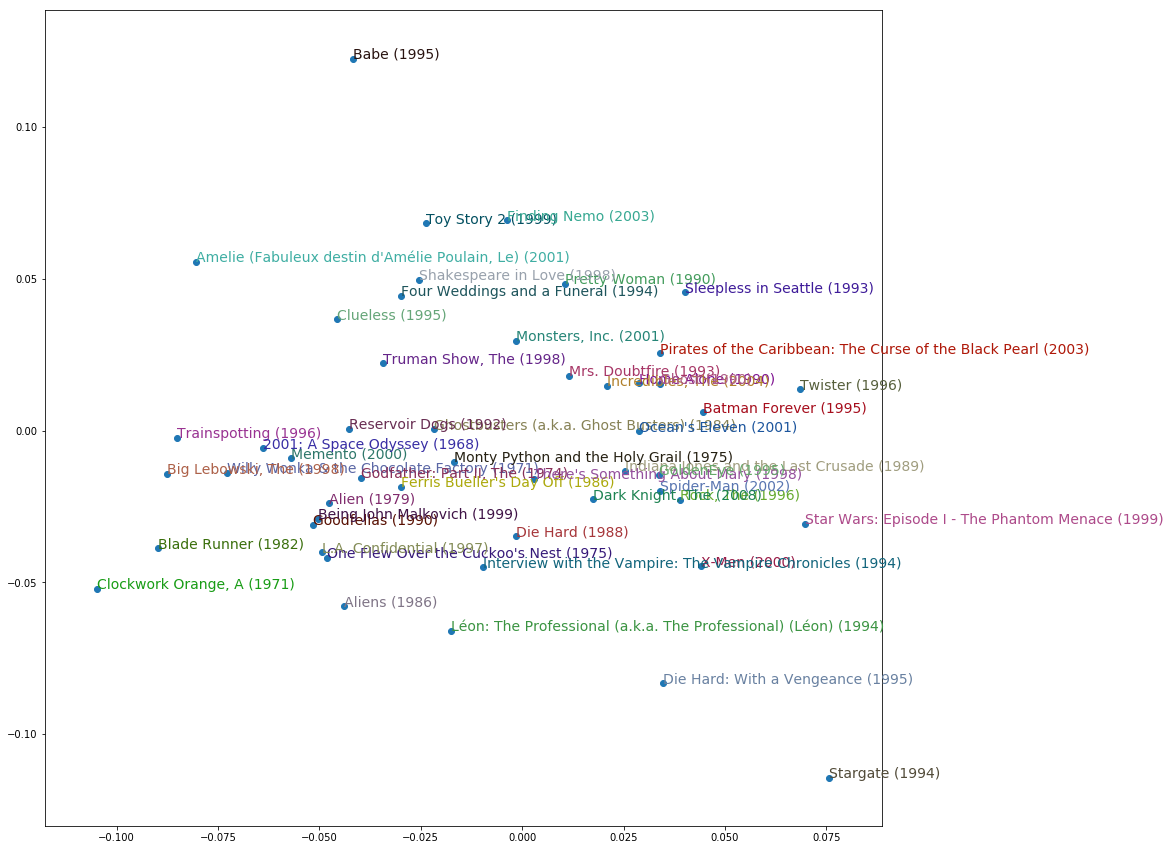

In [115]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [116]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [123]:
def relu_advanced(x):
    return K.relu(x, max_value=1)

x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1, activation=relu_advanced)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [124]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [125]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80101 samples, validate on 19903 samples
Epoch 1/8
80101/80101 [==============================] - 3s - loss: 7.7986 - val_loss: 7.6188
Epoch 2/8
80101/80101 [==============================] - 3s - loss: 7.5969 - val_loss: 7.6145
Epoch 3/8
80101/80101 [==============================] - 3s - loss: 7.5916 - val_loss: 7.6108
Epoch 4/8
80101/80101 [==============================] - 3s - loss: 7.5884 - val_loss: 7.6086
Epoch 5/8
80101/80101 [==============================] - 3s - loss: 7.5866 - val_loss: 7.6075
Epoch 6/8
80101/80101 [==============================] - 3s - loss: 7.5859 - val_loss: 7.6072
Epoch 7/8
80101/80101 [==============================] - 3s - loss: 7.5856 - val_loss: 7.6070
Epoch 8/8
80101/80101 [==============================] - 3s - loss: 7.5853 - val_loss: 7.6069


This improves on our already impressive accuracy even further!